In [1]:
import ast
import os
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten
from keras.models import Model
import numpy as np
import itertools
from keras.utils import np_utils
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from plot_util import plot_confusion_matrix
%matplotlib inline

# Model parameters
MAX_FEATURES = 183312
MAX_TEXT_LENGTH = 1024
EMBED_SIZE  = 100
BATCH_SIZE = 16
EPOCHS = 2
VALIDATION_SPLIT = 0.1

Using TensorFlow backend.


Nous lisons le jeu de données d'apprentissage et de test. Nous décidons de prendre le jeu de données de test, puis faire le découpage afin d'obtenir le jeu de données d'apprentissage utilisé et le jeu de données de test utilisé.

In [2]:
def split_datasets(data_path, test_size):
    x = []
    y = []
    with open(data_path, 'r') as f:
        for line in f:
            temp = line.split('__label__')
            x.append(temp[0])
            y.append(temp[1].replace('\n', ''))
            
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    print('Dataset splited.')
    return x_train, x_test, y_train, y_test

Nous allons d'abord tokenizer les données et les labels au format pour le réseau de neurones. Les données seront tokenizées et mises à la même longueur. Nous coupons les exemples trop longs et nous utilisons zero-padding pour les exemples courts.

In [3]:
def get_train_test(train_raw_text, test_raw_text):
    
    tokenizer = text.Tokenizer(num_words=MAX_FEATURES)

    tokenizer.fit_on_texts(list(train_raw_text))
    word_index = tokenizer.word_index
    train_tokenized = tokenizer.texts_to_sequences(train_raw_text)
    test_tokenized = tokenizer.texts_to_sequences(test_raw_text)
    return sequence.pad_sequences(train_tokenized, maxlen=MAX_TEXT_LENGTH), \
           sequence.pad_sequences(test_tokenized, maxlen=MAX_TEXT_LENGTH), \
           word_index


def class_str_2_ind(x_train, x_test, y_train, y_test):
    print('Converting data to trainable form...')
    le = preprocessing.LabelEncoder()
    n_out = len(CLASSES_LIST)
    le.fit(CLASSES_LIST)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    train_y_cat = np_utils.to_categorical(y_train, n_out)
    x_vec_train, x_vec_test, word_index = get_train_test(x_train, x_test)
    print('Number of training examples: ' + str(len(x_vec_train)))
    print('Number of training examples: ' + str(len(x_vec_test)))
    
    return x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index

Maintenant nous allons lire les vecteurs de mots pré-appris. Nous construissons aussi la matrice d'entrée depuis x_train et les vecteurs de mots. Cette partie est basé sur le [tutoriel de Keras](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) 

In [4]:
def get_embedding_index(vectors_file_path):
    embeddings_index = {}
    with open(vectors_file_path, 'r') as f:
        first_line = f.readline()
        #print(first_line)
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            
    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index


def get_embedding_matrix(word_index, embedding_index):
    print('Building embedding matrix...')
    embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    print('Embedding matrix built.')        
    return embedding_matrix

Nous définissons un modèle de classification de texte avec une couche de Conv1D et une couche de Dense. Nous pouvons utiliser les vecteurs de mots pré-appris. Le modèle est basé sur le [TP de M. Kermorvant](https://gitlab.com/kermorvant/nlp-labs).

In [5]:
def get_model(embedding_matrix, word_index):

    inp = Input(shape=(MAX_TEXT_LENGTH,))
    #modification here
    model = Embedding(len(word_index) + 1,
                      EMBED_SIZE,
                      weights=[embedding_matrix],
                      input_length=MAX_TEXT_LENGTH,
                      trainable=False)(inp)
    
    model = Dropout(0.5)(model)
    model = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dense(11, activation="softmax")(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


def train_fit_predict(model, x_train, x_test, y_train):
    
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS, verbose=1)

    return model.predict(x_test)

----
Nous entraînons le modèle.

In [6]:
data_path = 'datasets/news_fasttext_test.txt'
test_size = 0.01
x_train, x_test, y_train, y_test = split_datasets(data_path, test_size)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))
x_vec_train, x_vec_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, y_train, y_test)

Dataset splited.
Label categories: ['affairs' 'economic' 'edu' 'ent' 'fashion' 'game' 'home' 'house'
 'science' 'sports' 'stock']
Converting data to trainable form...
Number of training examples: 102335
Number of training examples: 1034


In [7]:
vectors_file_path = 'word2vec_skip.txt'
embedding_index = get_embedding_index(vectors_file_path)
embedding_matrix = get_embedding_matrix(word_index, embedding_index)
print('Building model...')
model = get_model(embedding_matrix, word_index)
y_predicted = train_fit_predict(model, x_vec_train, x_vec_test, train_y_cat).argmax(1)
print("Test Accuracy:", accuracy_score(y_test, y_predicted))

Found 183311 word vectors.
Building embedding matrix...
Embedding matrix built.
Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1024, 100)         50462800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1024, 32)          6432      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 512, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
____________________________________________

----
Nous allons plotter la matrice de confusion, code basé sur [l'exemple de sklearn](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

Confusion matrix, without normalization
Normalized confusion matrix


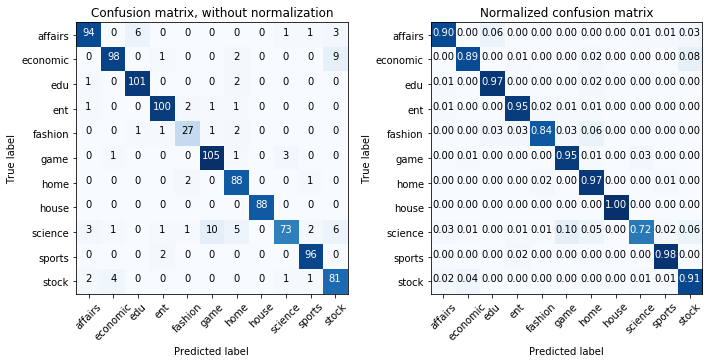

In [8]:
conf_mat = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(10,10))
plt.subplot(121)
plot_confusion_matrix(conf_mat, CLASSES_LIST, title='Confusion matrix, without normalization')
plt.subplot(122)
plot_confusion_matrix(conf_mat, CLASSES_LIST, normalize=True, title='Normalized confusion matrix')